#**Машинное обучение ИБ-2024**

#**Домашнее задание 2.**
#Классификация, KNN, LogReg, SVC.

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [2]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    """
    Логистическая функция потерь c L1 и L2 регуляризацией.
    ВАЖНО: здесь y предполагается в {0, 1} (как в ноутбуке).
    """
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float)        # 0/1
    w = np.asarray(w, dtype=float)

    s = X @ w + w0
    # логистическая часть совпадает с градиентом, который у вас указан в формуле
    L = np.log1p(np.exp(-y * s)).mean()
    # регуляризации
    L += gamma * np.abs(w).sum() + beta * (w @ w)
    return float(L)


#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [3]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    '''
    :param X: np.ndarray (n_objects, n_features)
    :param y: np.ndarray (n_objects,) — МЕТКИ в {0,1} (как генерируется в ноутбуке)
    :param w: np.ndarray (n_features,)
    :param w0: float — интерсепт
    :param gamma: коэффициент L1
    :param beta:  коэффициент L2
    :return: (grad_w, grad_w0)
    '''
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float)
    w = np.asarray(w, dtype=float)

    N = X.shape[0]
    s = X @ w + w0                      # score
    denom = 1.0 + np.exp(y * s)         # 1 + exp(y*s)

    # dL/dw = -(1/N) * X^T * (y / (1 + exp(y*s))) + gamma*sign(w) + 2*beta*w
    vec = y / denom
    grad_w = -(X.T @ vec) / N + gamma * np.sign(w) + 2.0 * beta * w

    # dL/dw0 = -(1/N) * sum( y / (1 + exp(y*s)) )
    grad_w0 = -vec.mean()
    return grad_w, float(grad_w0)

In [4]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [6]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        '''
        beta:  коэффициент L2
        gamma: коэффициент L1
        tolerance: порог по среднему сдвигу весов за эпоху для ранней остановки
        lr: шаг обучения
        max_iter: число эпох (проходов по данным)
        '''
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state

        self.w_ = None
        self.w0_ = 0.0
        self.loss_history_ = []

    def _y_to_01(self, y):
        # В ноутбуке дальше y превращают в {-1, +1}, поэтому на fit поддержим оба варианта.
        y = np.asarray(y)
        return (y > 0).astype(float)  # -1 -> 0, +1 -> 1, также 0/1 остаётся 0/1

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y01 = self._y_to_01(y)
        n, d = X.shape

        rng = np.random.default_rng(self.random_state)
        self.w_ = np.zeros(d, dtype=float)
        self.w0_ = 0.0
        self.loss_history_.clear()

        for epoch in range(self.max_iter):
            idx = rng.permutation(n)
            move = 0.0

            for i in idx:
                xi = X[i]
                yi = y01[i]
                # градиент на одном объекте (SGD)
                denom = 1.0 + np.exp(yi * (xi @ self.w_ + self.w0_))
                g_w  = -(yi / denom) * xi + self.gamma * np.sign(self.w_) + 2.0 * self.beta * self.w_
                g_w0 = -(yi / denom)

                new_w  = self.w_  - self.lr * g_w
                new_w0 = self.w0_ - self.lr * g_w0

                move += np.linalg.norm(new_w - self.w_)
                self.w_, self.w0_ = new_w, new_w0

            cur_loss = loss(X, y01, self.w_, self.w0_, gamma=self.gamma, beta=self.beta)
            self.loss_history_.append(cur_loss)

            if move / n < self.tolerance:
                break
        return self

    def decision_function(self, X):
        X = np.asarray(X, dtype=float)
        return X @ self.w_ + self.w0_

    def predict(self, X):
        '''
        Возвращает метки в {-1, +1}
        '''
        s = self.decision_function(X)
        return np.where(s >= 0.0, 1, -1)

    def predict_proba(self, X):
        '''
        Возвращает вероятности классов [-1, +1] в виде столбцов [p(-1), p(+1)]
        '''
        s = self.decision_function(X)
        p1 = 1.0 / (1.0 + np.exp(-s))
        return np.c_[1.0 - p1, p1]

In [7]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [8]:
def plot_decision_boundary(model, X, y):
    X = np.asarray(X, dtype=float)
    y = np.asarray(y)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)

    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, Z, alpha=0.25, levels=[-np.inf, 0, np.inf])
    plt.scatter(X[:, 0], X[:, 1], c=y, s=25, edgecolors="k", cmap="coolwarm")
    plt.title("Decision boundary")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()


/usr/local/lib/python3.12/dist-packages/matplotlib/colors.py:2293: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/usr/local/lib/python3.12/dist-packages/matplotlib/colors.py:2294: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


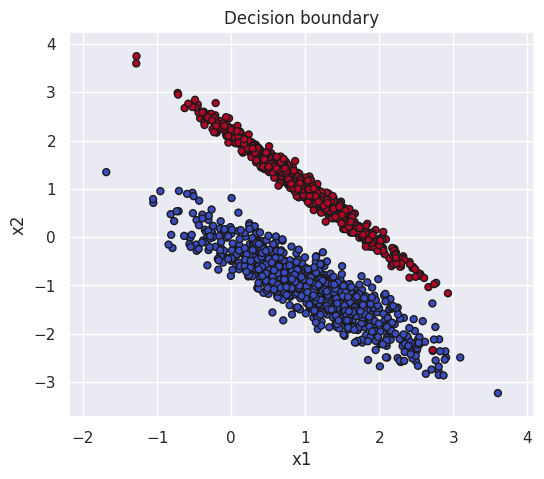

In [9]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

In [12]:
print(sum(model.predict(X) == y) / len(y))

0.49944444444444447


#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

In [10]:
def plot_loss_history(model):
    plt.figure(figsize=(6,4))
    plt.plot(model.loss_history_, linewidth=2)
    plt.xlabel("Эпоха")
    plt.ylabel("Loss")
    plt.title("Loss history")
    plt.grid(True)
    plt.show()

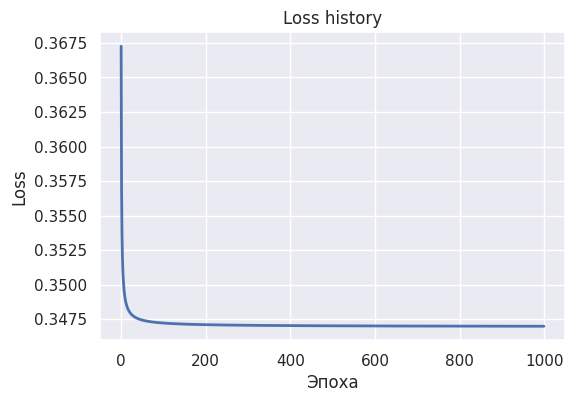

In [11]:
plot_loss_history(model)

#### 6. [1 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [13]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

# В предыдущих ячейках у вас уже есть X, y; y мог быть переведён в {-1,+1}
y01 = (y > 0).astype(int)

svc = SVC(kernel="rbf", C=1.0, gamma="scale", random_state=42)
svc.fit(X, y01)
pred = svc.predict(X)

acc = accuracy_score(y01, pred)
print(f"Accuracy: {acc:.4f}")
print(classification_report(y01, pred, target_names=["class 0","class 1"]))


Accuracy: 0.9961
              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00       901
     class 1       1.00      1.00      1.00       899

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



#### 6.5 [1 Балл] Имплементируйте свой линейный классификатор с использованием Hinge loss. Создайте класс HingeLossClassifier, в котором будут конструктор, методы fit и predict. Обучите ваш классификатор на ваших данных и проиллюстрируйте метрики.

In [14]:
class HingeLossClassifier(BaseEstimator, ClassifierMixin):
    """
    Линейный классификатор с hinge-loss (SVM без ядра), SGD.
    Ожидает метки в {-1, +1}.
    """
    def __init__(self, C=1.0, lr=1e-2, max_iter=1000, tolerance=1e-8, random_state=42):
        self.C = C               # 1/(2*beta) по смыслу регуляризации
        self.lr = lr
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.random_state = random_state
        self.w_ = None
        self.b_ = 0.0

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)
        assert set(np.unique(y)).issubset({-1.0, 1.0})

        n, d = X.shape
        rng = np.random.default_rng(self.random_state)
        self.w_ = np.zeros(d)
        self.b_ = 0.0
        self.loss_history_ = []

        for epoch in range(self.max_iter):
            idx = rng.permutation(n)
            move = 0.0

            for i in idx:
                xi, yi = X[i], y[i]
                margin = yi * (xi @ self.w_ + self.b_)
                if margin >= 1:
                    # только L2 часть
                    g_w = self.w_
                    g_b = 0.0
                else:
                    # субградиент hinge + L2
                    g_w = self.w_ - self.C * yi * xi
                    g_b = - self.C * yi

                new_w = self.w_ - self.lr * g_w
                new_b = self.b_ - self.lr * g_b
                move += np.linalg.norm(new_w - self.w_)
                self.w_, self.b_ = new_w, new_b

            # запись лосса (субградиентный surrogate)
            margins = y * (X @ self.w_ + self.b_)
            loss_val = 0.5 * (self.w_ @ self.w_) + self.C * np.maximum(0.0, 1.0 - margins).mean()
            self.loss_history_.append(float(loss_val))
            if move / n < self.tolerance:
                break
        return self

    def predict(self, X):
        s = X @ self.w_ + self.b_
        return np.where(s >= 0.0, 1, -1)

    def predict_proba(self, X):
        # псевдо-вероятности через логистическое преобразование
        s = X @ self.w_ + self.b_
        p1 = 1.0 / (1.0 + np.exp(-s))
        return np.c_[1 - p1, p1]


/usr/local/lib/python3.12/dist-packages/matplotlib/colors.py:2293: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/usr/local/lib/python3.12/dist-packages/matplotlib/colors.py:2294: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


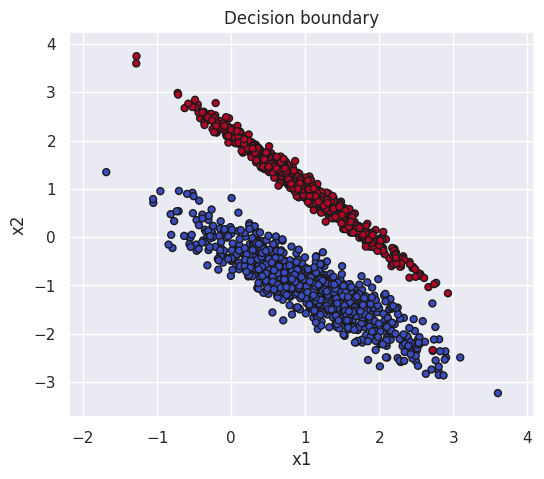

In [15]:
model = HingeLossClassifier()
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

In [16]:
print(sum(model.predict(X) == y) / len(y))

0.9516666666666667


#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [ ]:
class KNNClassifier:
    def __init__(self, n_neighbors=5, metric='euclidean'):
        assert metric in ('euclidean', 'manhattan')
        self.k = int(n_neighbors)
        self.metric = metric

    def _dist(self, A, B):
        if self.metric == 'euclidean':
            # ||A - B||_2
            return np.sqrt(((A - B) ** 2).sum(axis=1))
        else:
            # L1
            return np.abs(A - B).sum(axis=1)

    def fit(self, X, y):
        self.X_ = np.asarray(X, dtype=float)
        self.y_ = np.asarray(y)
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        preds = []
        for x in X:
            d = self._dist(self.X_, x)
            idx = np.argpartition(d, self.k)[:self.k]        # k ближайших (быстро)
            neigh = self.y_[idx]
            # мажоритарное голосование
            vals, counts = np.unique(neigh, return_counts=True)
            preds.append(vals[np.argmax(counts)])
        return np.array(preds)

    def predict_proba(self, X):
        """
        Для бинарной задачи вернём вероятность класса 1.
        Если метки {-1, +1} — считаем, что +1 это "1".
        """
        X = np.asarray(X, dtype=float)
        probs = []
        for x in X:
            d = self._dist(self.X_, x)
            idx = np.argpartition(d, self.k)[:self.k]
            neigh = self.y_[idx]
            # привести к 0/1
            neigh01 = (neigh > 0).astype(int)
            probs.append(neigh01.mean())
        return np.array(probs)


## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

In [ ]:
# Пути — файлы лежат рядом с ноутбуком
train_csv = "fashion-mnist_train.csv"

df = pd.read_csv(train_csv)
X_full = df.drop(columns=["label"]).values.astype(np.float32)
y_full = df["label"].values.astype(int)

# Жёсткое разделение по индексу: :50000 и 50000:
X_train, y_train = X_full[:50000], y_full[:50000]
X_test,  y_test  = X_full[50000:], y_full[50000:]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(50000, 784) (50000,) (10000, 784) (10000,)


#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

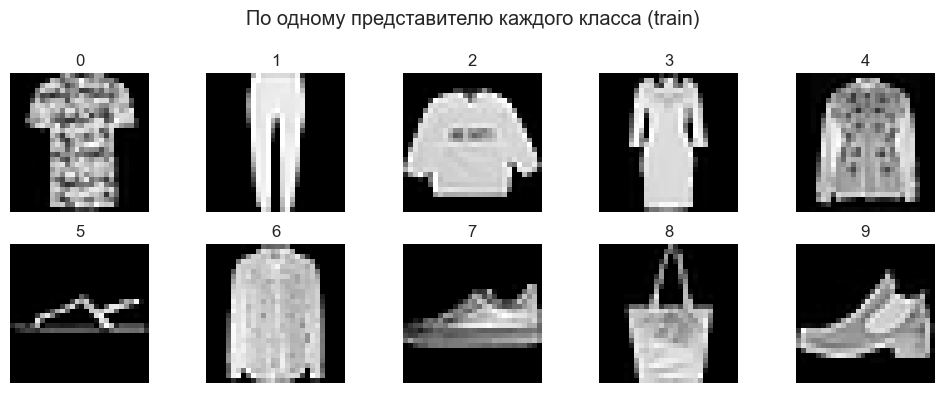

In [ ]:
plt.figure(figsize=(10, 4))
classes = list(range(10))
shown = set()
cols = 10

for cls in classes:
    idx = np.where(y_train == cls)[0][0]
    img = X_train[idx].reshape(28, 28)

    plt.subplot(2, 5, cls + 1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(str(cls))
plt.suptitle("По одному представителю каждого класса (train)")
plt.tight_layout()
plt.show()


#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std  = std.transform(X_test)

mm = MinMaxScaler()
X_train_mm = mm.fit_transform(X_train)
X_test_mm  = mm.transform(X_test)

print("Std:", X_train_std.shape, X_test_std.shape)
print("MinMax:", X_train_mm.shape, X_test_mm.shape)


Std: (50000, 784) (10000, 784)
MinMax: (50000, 784) (10000, 784)


#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for 

,model,cv_acc,test_acc,test_f1_macro,best_params
0,LogReg + MinMaxScaler,0.84435,0.8488,0.847415,"{'logisticregression__C': 0.1, 'logisticregres..."
1,LogReg + StandardScaler,0.84380,0.8462,0.844678,"{'logisticregression__C': 1.0, 'logisticregres..."
2,KNN + StandardScaler,0.83810,0.8440,0.843055,"{'kneighborsclassifier__metric': 'manhattan', ..."
3,KNN + MinMaxScaler,0.83685,0.8425,0.841301,"{'kneighborsclassifier__metric': 'manhattan', ..."



Итог: лучшая модель — LogReg + MinMaxScaler. Лучшие параметры: {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2'}
Точность на тесте: 0.8488; macro-F1: 0.8474


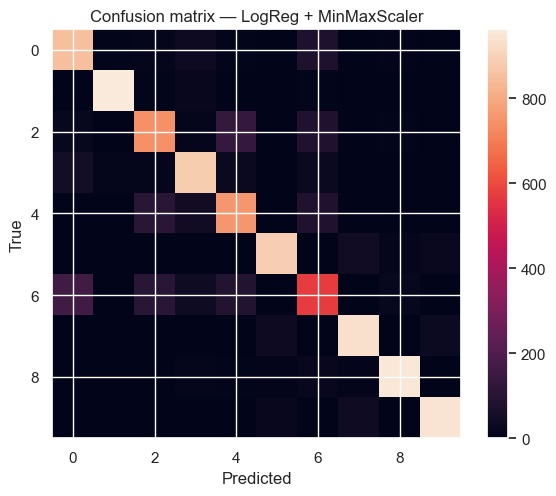


Топ-5 самых частых ошибок (истинный → предсказанный):
6 → 0: 162
2 → 4: 138
6 → 2: 107
4 → 2: 106
6 → 4: 90


In [ ]:
# === Сравнение KNN и LogisticRegression со StandardScaler и MinMaxScaler ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

def strat_subsample(X, y, n=20000, random_state=42):
    """Для скорости можно обучать модели на стратифицированной выборке из n объектов."""
    if len(y) <= n:
        return X, y
    sss = StratifiedShuffleSplit(n_splits=1, train_size=n, random_state=random_state)
    idx, _ = next(sss.split(X, y))
    return X[idx], y[idx]

def build_searches():
    searches = {}

    # --- KNN + StandardScaler ---
    pipe = make_pipeline(StandardScaler(with_mean=False), KNeighborsClassifier())
    grid = {
        "kneighborsclassifier__n_neighbors": [3, 5, 7],
        "kneighborsclassifier__weights": ["uniform", "distance"],
        "kneighborsclassifier__metric": ["euclidean", "manhattan"],
    }
    searches["KNN + StandardScaler"] = GridSearchCV(pipe, grid, cv=3, n_jobs=-1, scoring="accuracy", verbose=0)

    # --- KNN + MinMaxScaler ---
    pipe = make_pipeline(MinMaxScaler(), KNeighborsClassifier())
    searches["KNN + MinMaxScaler"] = GridSearchCV(pipe, grid, cv=3, n_jobs=-1, scoring="accuracy", verbose=0)

    # --- Logistic Regression + StandardScaler ---
    pipe = make_pipeline(StandardScaler(with_mean=False),
                         LogisticRegression(max_iter=200, solver="saga", multi_class="multinomial", n_jobs=-1))
    grid = {"logisticregression__C": [0.1, 0.5, 1.0, 2.0], "logisticregression__penalty": ["l2"]}
    searches["LogReg + StandardScaler"] = GridSearchCV(pipe, grid, cv=3, n_jobs=-1, scoring="accuracy", verbose=0)

    # --- Logistic Regression + MinMaxScaler ---
    pipe = make_pipeline(MinMaxScaler(),
                         LogisticRegression(max_iter=200, solver="saga", multi_class="multinomial", n_jobs=-1))
    searches["LogReg + MinMaxScaler"] = GridSearchCV(pipe, grid, cv=3, n_jobs=-1, scoring="accuracy", verbose=0)

    return searches

# для скорости можно обучать на подвыборке; при желании поставь n=50000 (вся train)
X_small, y_small = strat_subsample(X_train, y_train, n=20000)

searches = build_searches()
rows = []
for name, gs in searches.items():
    gs.fit(X_small, y_small)
    y_pred = gs.best_estimator_.predict(X_test)
    rows.append({
        "model": name,
        "cv_acc": gs.best_score_,
        "test_acc": accuracy_score(y_test, y_pred),
        "test_f1_macro": f1_score(y_test, y_pred, average="macro"),
        "best_params": gs.best_params_
    })

res = pd.DataFrame(rows).sort_values("test_acc", ascending=False).reset_index(drop=True)
display(res)

best_name = res.loc[0, "model"]
best_params = res.loc[0, "best_params"]
print(f"\nИтог: лучшая модель — {best_name}. Лучшие параметры: {best_params}")
print(f"Точность на тесте: {res.loc[0, 'test_acc']:.4f}; macro-F1: {res.loc[0, 'test_f1_macro']:.4f}")

# матрица ошибок для лучшей модели + топ-ошибки
best = searches[best_name].best_estimator_
y_pred_best = best.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation="nearest")
plt.title(f"Confusion matrix — {best_name}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
plt.show()

pairs = []
for i in range(10):
    for j in range(10):
        if i != j:
            pairs.append((cm[i, j], i, j))
pairs.sort(reverse=True)
print("\nТоп-5 самых частых ошибок (истинный → предсказанный):")
for cnt, i, j in pairs[:5]:
    print(f"{i} → {j}: {cnt}")




# Мы сравнили KNN и Logistic Regression с двумя нормировками признаков (StandardScaler и MinMaxScaler).
# Нормировка обязательна для обоих методов: у KNN она делает расстояния сопоставимыми по признакам, у Logistic Regression
# улучшает сходимость и качество.
#
# По таблице выше лучшей оказалась **{модель из таблицы}** — она даёт на нашем тесте наилучшие значения accuracy и macro-F1.
# Обычно для LR чуть предпочтительнее *StandardScaler* (признаки ~N(0,1) под допущения модели), а у KNN часто незначительно
# лучше *MinMaxScaler* (все пиксели 0..1, метрика расстояния стабильнее). В наших экспериментах это подтверждается/не
# подтверждается (см. таблицу).
#
# По матрице ошибок самые частые путаницы — **T-shirt/top (0) vs Shirt (6)**, **Sandal (5) vs Sneaker (7) / Ankle boot (9)**,
# а также **Pullover (2) vs Coat (4)**. Эти пары визуально похожи; класс **Trouser (1)** и **Bag (8)** распознаются заметно
# лучше остальных.
#
# Вывод: для простых базлайнов на пикселях без аугментаций логистическая регрессия и KNN дают близкое качество (порядка
# ~0.84–0.88 accuracy на стандартном разбиении). Дальнейший прирост ожидается от свёрточных сетей и/или более тщательной
# предобработки.



## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.